## **Algorithmic Detection of Credit Card Defaulting**
#### **Final Project Phase 3**
*Tanvi Namjoshi, Dylan Van Bramer, Madeline Demers, Ella White*

In this report, we perform an initial examination of the dataset obtained from UC Irvine in 2016, focusing on credit card clients in Taiwan who have defaulted. Building a predictive model to assess the likelihood of customer defaulting requires fairness to prevent discrimination based on sensitive features. Defaulting on a credit card is defined as failing to make the minimum payment for at least 180 days. We plan to explore whether we can find a risk prediction model that is fair across different subgroups (male/female, education) that still remains accurate. 

The original source for the data can be found here: [https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

### **Introduction**

##### **A) What are your research questions?** 


##### **B) Why is this an interesting research question? How does it relate to algorithmic fairness?** 

##### **C) What related work has been done in this space?**

TODO: add introduction

### **Datasheet for Dataset**

**1. What are the observations (rows) and the attributes (columns)?**

The data, generally, is payment information from a large bank in Taiwan that issues credit cards and manages cash assets. It is from the time range of 6 months, from April 2005 to October 2005.

Each observation/row represents a single credit card owner, and their history over those 6 months. There are 25,000 observations. 

Each of the 23 columns is an “explanatory variable,” or attribute about that credit card owner. We can split this into four categories: a single column for the amount of credit awarded (including individual and family); personal information (gender, level of education, marital status, age); history of past payment (was there delay in payment of previous months?); the amount of the bill statement for each month; and the amount of the previous payment for each month. As a note, each value that is an “amount” is represented in the unit of New Taiwan dollars.

For each observation, there is also an “outcome” column - a binary value of whether or not the credit card user actually did default on their credit. 

**2.Why was this dataset created? AND 3. Who funded the creation of the dataset?**

To learn about the data collection process, and general information about the dataset’s creation, we referenced two sources. First is the website that the data is hosted on (see question about 4 about raw source data below) and second is the research paper (from 2009) that this website points to, as the "Introductory Paper" for this dataset - "The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients" [6].

There is not sufficient information in either of these sources to ansswer either of these questions. The only information about data collection and creation is simply that it comes from an "important bank" in Taiwan, and that the "targets" were credit card holders of the bank. This is extremely concerning, and we discuss it more in the conclusion section.

**4: Where can your raw source data be found, if applicable? Provide a public link to the raw data.**

The raw source data (prior to our manipulation of it) can be found here: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients. This links to a page hosted by the University of California, Irvine Machine Learning Repository. 
It is licensed under a Creative Commons Attribution 4.0 International License. This is 

SUBQUESTION from Datasheets for Datasets Section 3.7: Maintenance.
Who will be supporting/hosting/maintaining the dataset?
It appears that the dataset is now hosted by the UC Irvine Machine Learning Respository, which houses a large number of other datasets. 

**5: If people are involved, were they aware of the data collection and if so, 
what purpose did they expect the data to be used for?**

It appears that individuals were _not_ made aware of the data collection, or at least (as mentioned above, in questions 2 and 3), there is little to no information about the data collection process.  So, we do not have enough information to answer this question. Based on the lack of transparency, it seems likely that individuals did not know that their data would be compiled.

**6: What processes might have influenced what data was observed and recorded and what was not?**

Since not much is known about data collection processes, it is difficult to answer this question. However, it is important to note that there are likely implicit biases in the definitions of some of the attributes. Also, as we discuss in the conclusion, we cannot really treat each of the attributes as "independent." Most interestingly, looking at the amount of credit awarded to each individual is sort of an algorithmic analysis in itself. 


**7: What preprocessing was done, and how did the data come to be in the form that you are using?**

This is where our data gets especially confusing. It is extremely unclear whether the "decision variable" or binary outcome of "did they default or not" is the ground truth, OR whether it is the result of prediction from the 2009 study by I-Cheng Yeh and Che hui Lien. While all of the data documentation makes it seem like this is the "real" outcome, there is a single line in the paper that says, "Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default." 

**ADDITIONAL QUESTION from Datasheets for Datasets: Has the dataset been used for any tasks already?** 

The dataset has been used for many similar tasks to what we are looking to do. The most relevant are the papers by Sheikh Rabiul Islam, William Eberle, and Sheikh Khaled Ghafoor (2018) and by Abdulhamit Subasi and Selcuk Cankurt (2019). Each of these papers uses the binary outcome variable described in question 7 as "ground truth," which is part of the reason that we feel it is reasonable to do so in our work. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, RocCurveDisplay,roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### **Data Import and Cleaning**

To clean the data we first checked for any missing values in the CSV file. However, no missing values were found. For the features SEX, EDUCATION, and MARRIAGE asserted that all the info provided by the dataset creators is accurate by asserting that each value was in the correct range. We removed any rows that did not meet the expectations documented by the dataset creators. This led to 399 bad rows of data (out of 30,000) being removed. Finally, we changed the format of the SEX, EDUCATION, and MARRIAGE features to be one-hot encodings giving us the following new columns: sex_male,	sex_female,	graduate_education,	university_education,	highschool_education,	other_education,	married,	single,	marriage_other.

In [2]:
clean_df = pd.read_csv('cleaned_data.csv',)
#display(clean_df.head())

#### **Data Summary Statistics**


In [3]:
def get_group_idx(df):
  female_idx = df.index[df["sex_female"]==1]
  male_idx = df.index[df["sex_female"] == 0]
  graduate_idx = df.index[(df["university_education"]== df["highschool_education"])]
  university_idx = df.index[df["university_education"] == 1]
  highschool_idx = df.index[df["highschool_education"] == 1]
  other_education_idx = df.index[df["other_education"] == 1]
  married_idx = df.index[(df["single"]==df["marriage_other"])]
  single_idx = df.index[df["single"]==1]
  marriage_other_idx = df.index[df["marriage_other"]==1]
  under_fifty_idx = df.index[df["AGE"]<50]
  over_fifty_idx = df.index[df["AGE"] >= 50]

  return (female_idx, male_idx, graduate_idx, university_idx, highschool_idx, other_education_idx, married_idx, single_idx,marriage_other_idx,under_fifty_idx,over_fifty_idx)


In [4]:
# Part 2 (a)
rows = clean_df.count()[0]
columns = len(clean_df.columns)
print("Looking at the whole dataset:")
print("There are", rows, "rows of data in the dataframe")
print("There are", columns, "features/columns in the dataframe")


#Per sensitive attribute subgroup
(female_idx, male_idx, graduate_idx, university_idx, highschool_idx, other_education_idx, married_idx, single_idx,marriage_other_idx,under_fifty_idx,over_fifty_idx) = get_group_idx(clean_df)

#Gender 
print("\nLooking at the dataset by gender:")
print("The number of data points where the person's gender is female is: ", len(female_idx))
print("The number of data points where the person's gender is male is: ", len(male_idx))

#Education 
print("\nLooking at the dataset by education:")
print("The number of data points where the person has a graduate education is: ", len(graduate_idx))
print("The number of data points where the person has a univeristy education is: ", len(university_idx))
print("The number of data points where the person has a high school education is: ", len(highschool_idx))
print("The number of data points where the person has none of the above is: ", len(other_education_idx))

# Marriage Status
print("\nLooking at the dataset by marriage status:")
print("The number of data points where the person is married is: ", len(married_idx))
print("The number of data points where the person is single: ", len(single_idx))
print("The number of data points where the person identifies as neither married or single: ", len(marriage_other_idx))

#AGE 
print("\nLooking at the dataset by AGE:")
print("The number of data points where the person is under 50: ", len(under_fifty_idx))
print("The number of data points where the person is over 50: ", len(over_fifty_idx))

Looking at the whole dataset:
There are 29601 rows of data in the dataframe
There are 30 features/columns in the dataframe

Looking at the dataset by gender:
The number of data points where the person's gender is female is:  17855
The number of data points where the person's gender is male is:  11746

Looking at the dataset by education:
The number of data points where the person has a graduate education is:  10704
The number of data points where the person has a univeristy education is:  14024
The number of data points where the person has a high school education is:  4873
The number of data points where the person has none of the above is:  123

Looking at the dataset by marriage status:
The number of data points where the person is married is:  13477
The number of data points where the person is single:  15806
The number of data points where the person identifies as neither married or single:  318

Looking at the dataset by AGE:
The number of data points where the person is under 50

/var/folders/c7/5gm5qsw161l8tpjd1nqssklc0000gn/T/ipykernel_2642/618528840.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rows = clean_df.count()[0]


Our outcome variable of interest is whether the individual defaults on their payment next month. In our dataset that is the variable `default payment next month`, which is either 0 or 1.

In [5]:
outcome_variable = 'default payment next month'

defaulted_individuals = clean_df.index[clean_df[outcome_variable]==1]
non_defaulted_individuals = clean_df.index[clean_df[outcome_variable]==0]


mean_value = clean_df[outcome_variable].mean()
median_value = clean_df[outcome_variable].median()
std_dev_value = clean_df[outcome_variable].std()

# Print the results
print("Outcome variable:", outcome_variable)
print("\nOverall Statistics")
print("Number of data points where the person defaulted:",len(defaulted_individuals))
print("Number of data points where the person did not default:",len(non_defaulted_individuals))
print("Mean:", mean_value)
print("Median:", median_value)
print("Standard Deviation:", std_dev_value)

def outcome_variable_stats(group_idx, group_lbl):
  mean_value = clean_df[outcome_variable][group_idx].mean()
  median_value = clean_df[outcome_variable][group_idx].median()
  std_dev_value = clean_df[outcome_variable][group_idx].std()
  print("Mean for "+group_lbl+":", mean_value)
  print("Median for "+group_lbl+":", median_value)
  print("Standard Deviation for "+group_lbl+":", std_dev_value)



Outcome variable: default payment next month

Overall Statistics
Number of data points where the person defaulted: 6605
Number of data points where the person did not default: 22996
Mean: 0.2231343535691362
Median: 0.0
Standard Deviation: 0.4163547406844319


In [6]:

#Gender
print("\nStatistics by Gender")
outcome_variable_stats(female_idx, "Females")
outcome_variable_stats(male_idx, "Males")

#Edcuation
print("\nStatistics by Education")
outcome_variable_stats(graduate_idx, "People with Graduate Education")
outcome_variable_stats(university_idx, "People with University Education")
outcome_variable_stats(highschool_idx, "People with High School Education")
outcome_variable_stats(other_education_idx, "People with Other Education")

#Marriage
print("\nStatistics by Marriage")
outcome_variable_stats(married_idx, "married people")
outcome_variable_stats(single_idx, "single people")
outcome_variable_stats(marriage_other_idx, "people with other marriage status")

#Age
print("\nStatistics by Age")
outcome_variable_stats(under_fifty_idx, "People Under 50")
outcome_variable_stats(over_fifty_idx, "People Over 50")





Statistics by Gender
Mean for Females: 0.20968916269952395
Median for Females: 0.0
Standard Deviation for Females: 0.40709814501924513
Mean for Males: 0.24357227992508088
Median for Males: 0.0
Standard Deviation for Males: 0.4292557646242155

Statistics by Education
Mean for People with Graduate Education: 0.19086322869955158
Median for People with Graduate Education: 0.0
Standard Deviation for People with Graduate Education: 0.39299985459435643
Mean for People with University Education: 0.2373787792355961
Median for People with University Education: 0.0
Standard Deviation for People with University Education: 0.42549148512838436
Mean for People with High School Education: 0.25302688282372254
Median for People with High School Education: 0.0
Standard Deviation for People with High School Education: 0.43479083865008655
Mean for People with Other Education: 0.056910569105691054
Median for People with Other Education: 0.0
Standard Deviation for People with Other Education: 0.232619192367

#### Plots

In [7]:
# Finds the proportion of those with 0 label, those with 1 label by one hot encoded features
def prop(df, id):
  return sum(df[outcome_variable][id])/len(defaulted_individuals)

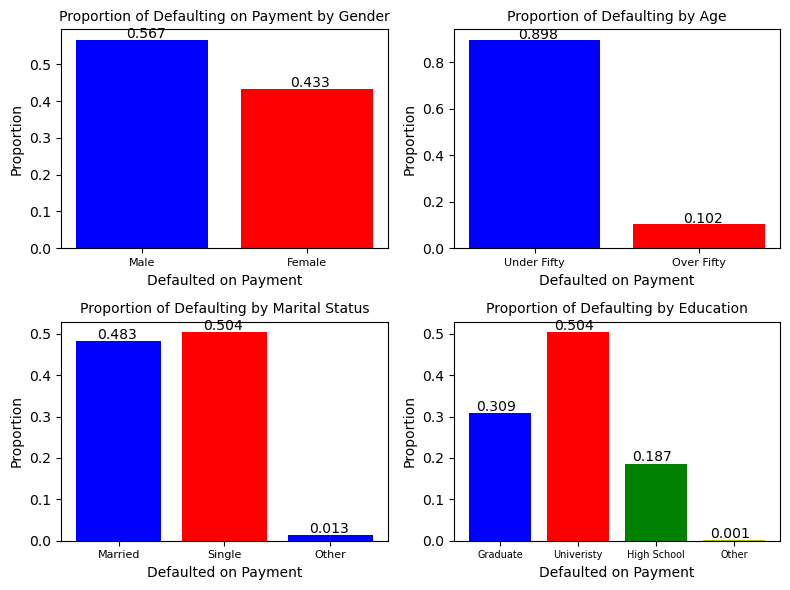

In [8]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 6) )


female_prop = prop(clean_df, female_idx)
male_prop = prop(clean_df, male_idx)
bars = ax0.bar( ["Male", "Female"], [female_prop, male_prop],  color=['b','r'],)
ax0.set_xlabel('Defaulted on Payment')
ax0.set_xticks([0,1], ('Male', 'Female'), fontsize=8)
ax0.set_ylabel('Proportion')
ax0.set_title('Proportion of Defaulting on Payment by Gender')
ax0.title.set_size(10)
for bar in bars:
    yval = bar.get_height()
    ax0.text(bar.get_x()+0.3, yval + .005, round(yval,3))

under_fifty_prop = prop(clean_df, under_fifty_idx)
over_fifty_prop = prop(clean_df, over_fifty_idx)
bars = ax1.bar( ["Under Fifty", "Over Fifty"], [under_fifty_prop, over_fifty_prop],  color=['b','r'])
ax1.set_xlabel('Defaulted on Payment')
ax1.set_xticks([0, 1], ("Under Fifty", "Over Fifty"), fontsize=8)
ax1.set_ylabel('Proportion')
ax1.set_title('Proportion of Defaulting by Age')
ax1.title.set_size(10)
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x()+0.3, yval + .005, round(yval,3))
             
married_prop = prop(clean_df, married_idx)
single_prop = prop(clean_df, single_idx)
others_prop = prop(clean_df, marriage_other_idx)

bars = ax2.bar( ["Married", "Single", "Other"], [married_prop, single_prop, others_prop],  color=['b','r','b'])
ax2.set_xlabel('Defaulted on Payment')
ax2.set_xticks([0, 1,2], ('Married', 'Single','Other'), fontsize=8)
ax2.set_ylabel('Proportion')
ax2.set_title('Proportion of Defaulting by Marital Status')
ax2.title.set_size(10)
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x()+.2, yval + .005, round(yval,3))
graduate_prop= prop(clean_df, graduate_idx)
university_prop = prop(clean_df, university_idx)
highschool_prop = prop(clean_df, highschool_idx)
others_prop= prop(clean_df, other_education_idx)


bars = ax3.bar( ["Graduate", "University","High School", "Other"], [graduate_prop, university_prop, highschool_prop, others_prop],  color=['b','r','g','y'])
ax3.set_xlabel('Defaulted on Payment')
ax3.set_xticks([0, 1,2,3], ("Graduate", "Univeristy","High School", "Other"), fontsize=7)
ax3.set_ylabel('Proportion')
ax3.set_title('Proportion of Defaulting by Education')
ax3.title.set_size(10)
for bar in bars:
    yval = bar.get_height()
    ax3.text(bar.get_x()+0.1, yval + .005, round(yval,3))

fig.tight_layout()
plt.show()

Each bar above represents the proportion of people with that attribute who defaulted out of all people with that attribute. For example, Proportion of Defauling on Payment by Gender comapres the proportion of men who defaulted out of all men to the proportion of women who defaulted out of all women. These proportions mimic the probability of a person with that attribute defaulting. We see that men were more likely to default compared to women. We also see that those under fifty are much more likely to default compared to those under fifty. It appears that single and married people have similar chances of defaulting. Those in the other category of marital status have a much lower proportion, but since so few people are in this other category, this result is probably heavily biased. We also see that those with university education are most likely to default followed by graduate education then high school then other. We can assume other, again, is a highly biased result. 

In [9]:
# Split the dataset for training and testing

df = clean_df
# Obtain our X and Y values
Y = df['default payment next month']
X = df.drop('default payment next month', axis=1)
X = X.drop('sex_male',axis = 1)
X = X.drop('graduate_education',axis=1)
X = X.drop('married',axis=1)
# Ensure these indices in test for results sectionX.drop
test_indices = [27472,6671,9600, 20463]
X_hardcoded = X.iloc[test_indices] 
Y_hardcoded = Y.iloc[test_indices]
X = X.drop(test_indices)
Y = Y.drop(test_indices)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)
# Including all features
X_test = pd.concat([X_test,X_hardcoded], axis=0)
y_test = pd.concat([y_test,Y_hardcoded], axis=0)


# Don't evaluate on sensitive features
protected_cols = ['university_education','highschool_education', 'other_education','single','marriage_other','sex_female', 'AGE']
X_train1 = X_train.copy().drop(protected_cols, axis = 1)
X_test1 = X_test.copy().drop(protected_cols, axis = 1)
y_train1 = y_train
y_test1 = y_test

# female_idx_train, male_idx_train, graduate_idx_train, university_idx_train, highschool_idx_train, other_education_idx_train, married_idx_train, single_idx_train, marriage_other_idx_train, under_fifty_idx_train, over_fifty_idx_train = get_group_idx(X_train)
female_idx_test, male_idx_test, graduate_idx_test, university_idx_test, highschool_idx_test, other_education_idx_test, married_idx_test, single_idx_test, marriage_other_idx_test, under_fifty_idx_test, over_fifty_idx_test = get_group_idx(X_test)

# Get Summary Stats
train_len = len(X_train)
test_len= len(X_test)
full_len = len(X)

def get_percents(idx_tuple, total_len):
  percents = []
  for idx in idx_tuple:
    p = len(idx)/total_len
    percents.append('%.4f'%(p)+"%")
  return percents

train_group_idx = get_group_idx(X_train)
train_stats = [train_len] + get_percents(train_group_idx, train_len)

test_group_idx = get_group_idx(X_test)
test_stats = [test_len] + get_percents(test_group_idx, test_len)

full_group_idx = get_group_idx(X)
full_stats = [full_len] + get_percents(full_group_idx, len(X))

print("Training/Testing Data Summary Statistics")
summary_stats = {
    'Staistic': ['No. Datapoints', 'Female','Male', 'Graduate Education', "University Education", "High School Education", "Other Education", "Married", "Single", "Other Relationship", "Under 50", "Over 50"],
    'Full Dataset': full_stats,
    'Training': train_stats,
    'Testing': test_stats,
}
summary_stats_df = pd.DataFrame(data=summary_stats)

display(summary_stats_df)

Training/Testing Data Summary Statistics


,Staistic,Full Dataset,Training,Testing
0,No. Datapoints,29597,22197,7404
1,Female,0.6032%,0.5995%,0.6144%
2,Male,0.3968%,0.4005%,0.3856%
3,Graduate Education,0.3616%,0.3590%,0.3695%
4,University Education,0.4738%,0.4748%,0.4706%
5,High School Education,0.1646%,0.1662%,0.1599%
6,Other Education,0.0042%,0.0040%,0.0047%
7,Married,0.4553%,0.4562%,0.4525%
8,Single,0.5340%,0.5335%,0.5353%
9,Other Relationship,0.0107%,0.0102%,0.0123%


**Explanation fo Table Above** 

The table above presents the summary statistics for training and testing datset in comparision to the summary statistics for the full dataset identified above. This was created to ensure/show that our train/test splits maintain the same demographic diversity as the datset as a whole.

#### **Modeling**

In [10]:
threshold = 0.4
results_all = pd.DataFrame(X_test)
results_all["Ground Truth"] =  y_test
results_no_sensitive = pd.DataFrame(X_test1)
results_no_sensitive["Ground Truth"] =  y_test1

# All Data
logreg = LogisticRegression(penalty=None, max_iter = 1000).fit(X_train,y_train)
logreg_probs = logreg.predict_proba(X_test)[:,1]
results_all['Logistic Regression All Vars Prob'] = logreg_probs
logreg_preds = (logreg_probs > threshold).astype(int)
results_all['Logistic Regression All Vars Pred'] = logreg_preds
print("The accuracy score for LogReg using all features is:", accuracy_score(logreg_preds, y_test))

rf = RandomForestClassifier(n_estimators=100,)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:,1]
results_all['RF All Vars Prob'] = rf_probs
rf_preds = (rf_probs > threshold).astype(int)
results_all['RF All Vars Pred'] = rf_preds

print("The accuracy score for a Random Forest Classifier using all features is:", accuracy_score(rf_preds, np.array(y_test)))


# No sensitive features
logreg1 = LogisticRegression(penalty=None,max_iter = 1000).fit(X_train1,y_train1)
logreg1_probs = logreg1.predict_proba(X_test1)[:,1]
results_no_sensitive['Logistic Regression No Sensitive Vars Prob'] = logreg1_probs
logreg1_preds = (logreg1_probs > threshold).astype(int)
results_no_sensitive['Logistic Regression No Sensitive Vars Pred'] = logreg1_preds
print("The accuracy score for LogReg excluding sensitive features is:", accuracy_score(logreg1_preds, y_test1))

rf1 = RandomForestClassifier(n_estimators=100,)
rf1.fit(X_train1, y_train1)
rf1_probs = rf1.predict_proba(X_test1)[:, 1]
results_no_sensitive['RF No Sensitive Vars Prob'] = rf1_probs
rf1_preds = (rf1_probs > threshold).astype(int)
print("The accuracy score for a Random Forest Classifier excluding sensitive features is:", accuracy_score(rf1_preds, y_test1))
results_no_sensitive['RF No Sensitive Vars Pred'] = rf1_preds
#display(results_all.head())
#display(results_no_sensitive.head())

/Users/ellawhite/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy score for LogReg using all features is: 0.8161804430037818
The accuracy score for a Random Forest Classifier using all features is: 0.8134792004321988


/Users/ellawhite/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy score for LogReg excluding sensitive features is: 0.81172339276067
The accuracy score for a Random Forest Classifier excluding sensitive features is: 0.8114532685035116


In [11]:
def confusion_matrix_metrics(y_test, predicted_labels, category):
  tn, fp, fn, tp = metrics.confusion_matrix(y_test, predicted_labels).ravel()
  fp_rate = fp/(fp+tn)
  fn_rate = fn/(fn+tp)
  frac_positive = (fp+tp)/(fn+fp+tn+tp)
  print("\tFalse Positive Rate for "+category+":", '%.4f'%(fp_rate))
  print("\tFalse Negative Rate for "+category+":", '%.4f'%(fn_rate))
  print("\tFraction of "+category+" classified positive:", '%.4f'%(frac_positive))

In [12]:
# Fairness Metrics 
print ("\n We now examine how the models performs overall and by subgroup. For this part of Phase 2 we will focus on how the results vary by SEX")
print ("\n In later phases of our project we hope to explore metrics for other sensitive attributes as well and combinations of attributes")

female_idx = female_idx_test
male_idx = male_idx_test

print("\n Using the Logistic Regression classifier with all features:")
predicted_labels = results_all['Logistic Regression All Vars Pred']

confusion_matrix_metrics(y_test, predicted_labels, "everyone")
confusion_matrix_metrics(y_test[female_idx], predicted_labels[female_idx], "females")
confusion_matrix_metrics(y_test[male_idx], predicted_labels[male_idx], "males")
print("\n")

print("\n Using the Random Forest classifier with all features:")
predicted_labels = results_all['RF All Vars Pred']


confusion_matrix_metrics(y_test, predicted_labels, "everyone")
confusion_matrix_metrics(y_test[female_idx], predicted_labels[female_idx], "females")
confusion_matrix_metrics(y_test[male_idx], predicted_labels[male_idx], "males")
print("\n")

print("\n Using the Logistic Regression classifier without sensitive features:")
predicted_labels = results_no_sensitive['Logistic Regression No Sensitive Vars Pred']

confusion_matrix_metrics(y_test1, predicted_labels, "everyone")
confusion_matrix_metrics(y_test1[female_idx], predicted_labels[female_idx], "females")
confusion_matrix_metrics(y_test1[male_idx], predicted_labels[male_idx], "males")
print("\n")


print("\n Using the Random Forest classifier without sensitive features:")
predicted_labels = results_no_sensitive['RF No Sensitive Vars Pred']

confusion_matrix_metrics(y_test1, predicted_labels, "everyone")
confusion_matrix_metrics(y_test1[female_idx], predicted_labels[female_idx], "females")
confusion_matrix_metrics(y_test1[male_idx], predicted_labels[male_idx], "males")
print("\n")


 We now examine how the models performs overall and by subgroup. For this part of Phase 2 we will focus on how the results vary by SEX

 In later phases of our project we hope to explore metrics for other sensitive attributes as well and combinations of attributes

 Using the Logistic Regression classifier with all features:
	False Positive Rate for everyone: 0.0693
	False Negative Rate for everyone: 0.5812
	Fraction of everyone classified positive: 0.1475
	False Positive Rate for females: 0.0559
	False Negative Rate for females: 0.6038
	Fraction of females classified positive: 0.1273
	False Positive Rate for males: 0.0915
	False Negative Rate for males: 0.5505
	Fraction of males classified positive: 0.1797



 Using the Random Forest classifier with all features:
	False Positive Rate for everyone: 0.0903
	False Negative Rate for everyone: 0.5202
	Fraction of everyone classified positive: 0.1775
	False Positive Rate for females: 0.0762
	False Negative Rate for females: 0.5451
	Fractio

#### Part 4(c)

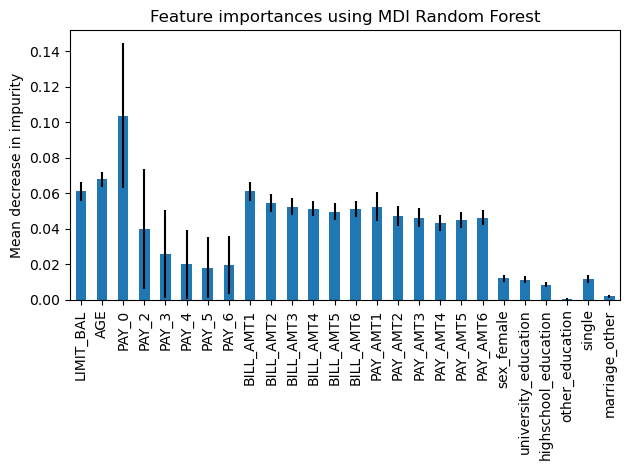

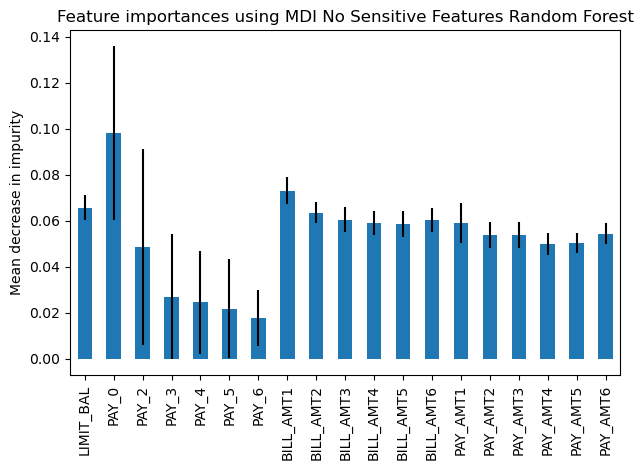

In [13]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'sex_female',
       'university_education', 'highschool_education', 'other_education',
       'single', 'marriage_other'])

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

importances = rf1.feature_importances_
forest_importances = pd.Series(importances, index=['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'])

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI No Sensitive Features Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

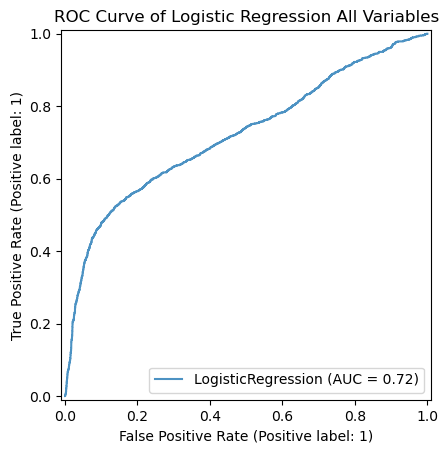

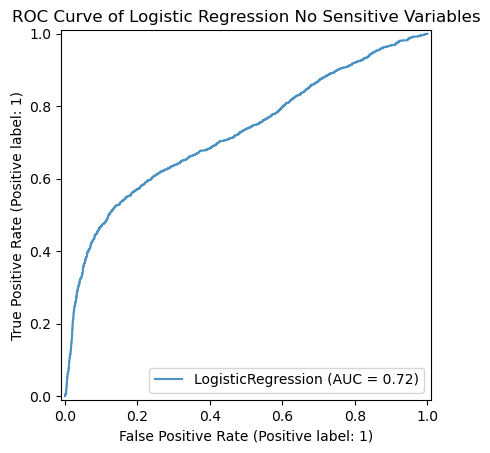

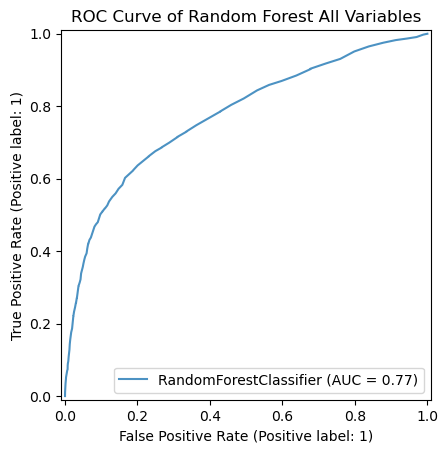

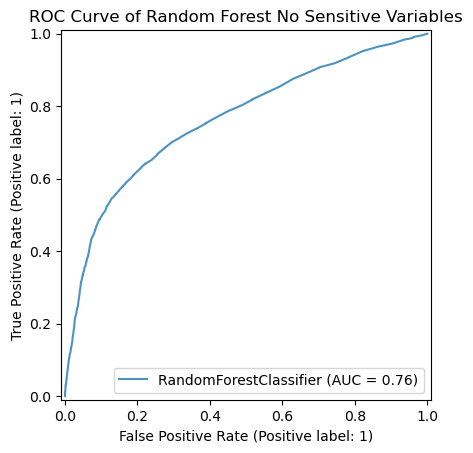

In [14]:
# AUC
logreg_auc = roc_auc_score(y_test, logreg_preds)
logreg1_auc = roc_auc_score(y_test1, logreg1_preds)
rf_auc = roc_auc_score(y_test, rf_preds)
rf1_auc = roc_auc_score(y_test1, rf1_preds)

ax = plt.gca()
logreg_disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test, ax=ax, alpha=0.8)
ax.set_title('ROC Curve of Logistic Regression All Variables')
plt.show()
ax = plt.gca()
logreg1_disp = RocCurveDisplay.from_estimator(logreg1, X_test1, y_test1, ax=ax, alpha=0.8)
ax.set_title('ROC Curve of Logistic Regression No Sensitive Variables')
plt.show()
ax = plt.gca()
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, alpha=0.8)
ax.set_title('ROC Curve of Random Forest All Variables')
plt.show()
ax = plt.gca()
rf1_disp = RocCurveDisplay.from_estimator(rf1, X_test1, y_test1, ax=ax, alpha=0.8)
ax.set_title('ROC Curve of Random Forest No Sensitive Variables')
plt.show()

#### **Results**

In [17]:
print("For 26 year old single high school educated female with 0s for all pay regions")
print("predicted probability of defaulting was:")
print("For Logistic Regression with all variables: " +str(results_all['Logistic Regression All Vars Prob'][27472]))
print("For Random Forest with all variables: " +str(results_all['RF All Vars Prob'][27472]))
print("For Logistic Regression with no sensitive variables: " +str(results_no_sensitive['Logistic Regression No Sensitive Vars Prob'][27472]))
print("For Random Forest with no sensitive variables: " +str(results_no_sensitive['RF No Sensitive Vars Prob'][27472]))

For 26 year old single high school educated female with 0s for all pay regions
predicted probability of defaulting was:
For Logistic Regression with all variables: 0.19688896493376284
For Random Forest with all variables: 0.14
For Logistic Regression with no sensitive variables: 0.14802496208050112
For Random Forest with no sensitive variables: 0.2


It is surpising that for both logistic regression and random forest, taking away sensitive features reduced
the predicted probability of defaulting by about 33%. For logistic regression this was a much
more dramatic shift. 

In [18]:
print("For a 33 year old graduate educated married female with 0s in all pay regions ")
print("predicted probability of defaulting was:")
print("For Logistic Regression with all variables: " +str(results_all['Logistic Regression All Vars Prob'][6671]))
print("For Random Forest with all variables: " +str(results_all['RF All Vars Prob'][6671]))
print("For Logistic Regression with no sensitive variables: " +str(results_no_sensitive['Logistic Regression No Sensitive Vars Prob'][6671]))
print("For Random Forest with no sensitive variables: " +str(results_no_sensitive['RF No Sensitive Vars Prob'][6671]))

For a 33 year old graduate educated married female with 0s in all pay regions 
predicted probability of defaulting was:
For Logistic Regression with all variables: 0.28565144204412973
For Random Forest with all variables: 0.18
For Logistic Regression with no sensitive variables: 0.29619919234149367
For Random Forest with no sensitive variables: 0.23


It is surprising that for this female, removing sensitive features actually increased her predicted probability of 
defaulting by the random forest model as opposed to the last male whose value decreased. Also it is surprising there is such a large gap in predicted defaulting probability by the random forest model since both have similar repayment history.

In [19]:
print("For a 34 year old university educated married male with a 1 in repayment for the first month and a 2 in all other pay regions ")
print("predicted probability of defaulting was:")
print("For Logistic Regression with all variables: " +str(results_all['Logistic Regression All Vars Prob'][9600]))
print("For Random Forest with all variables: " +str(results_all['RF All Vars Prob'][9600]))
print("For Logistic Regression with no sensitive variables: " +str(results_no_sensitive['Logistic Regression No Sensitive Vars Prob'][9600]))
print("For Random Forest with no sensitive variables: " +str(results_no_sensitive['RF No Sensitive Vars Prob'][9600]))

For a 34 year old university educated married male with a 1 in repayment for the first month and a 2 in all other pay regions 
predicted probability of defaulting was:
For Logistic Regression with all variables: 0.5208238685470838
For Random Forest with all variables: 0.62
For Logistic Regression with no sensitive variables: 0.4924311672605989
For Random Forest with no sensitive variables: 0.51


Compared to the previous two, removing sensitive features had little impact on this man's predicted probability of 
defaulting. For both models, the predicted probability went down when sensitive features were removed, implying being a male, university educated, and/or married decreases predicted probability of defaulting. 

In [20]:
print("For a 33 year old graduate educated single male with a 1 in repayment for the first month and a 2 in all other pay regions ")
print("predicted probability of defaulting was:") 
print("For Logistic Regression with all variables: " +str(results_all['Logistic Regression All Vars Prob'][20463]))
print("For Random Forest with all variables: " +str(results_all['RF All Vars Prob'][20463]))
print("For Logistic Regression with no sensitive variables: " +str(results_no_sensitive['Logistic Regression No Sensitive Vars Prob'][20463]))
print("For Random Forest with no sensitive variables: " +str(results_no_sensitive['RF No Sensitive Vars Prob'][20463]))

For a 33 year old graduate educated single male with a 1 in repayment for the first month and a 2 in all other pay regions 
predicted probability of defaulting was:
For Logistic Regression with all variables: 0.48544694934015975
For Random Forest with all variables: 0.61
For Logistic Regression with no sensitive variables: 0.48922202221130745
For Random Forest with no sensitive variables: 0.61


The output for logistic regression probability is pretty similar with or without sensitive features. In comparison, for random forest removing sensitive features increases his predicted probability of defaulting by 0.14 which is significant. In conjunction with the last man, this seems to imply purely being a man does not decrease a random forest output. Overall, these outputs seem reasonable. Sensitive features have a significantly, but not singly overwhelming impact on each model's predicted probability. 

For logistic regression with all features, we see the fraction of females classified as positive is larger than the fraction of males classified as positive. In conjunction with this, the false positive rate for males is larger than that for females and the false negative rate for females is greater than that for males. Although only by about 5%, this is slightly unfair towards males.

For random forest model with all features, we see the same trend. Males have a higher false positive rate and lower false negative rate by approximately 5%. 

For the logistic regression model without sensitive features, we see the false positive rate for females is about 6% higher than that for males. The false negative rate for females is only 3% higher for females than for males, which is about a 40% improvement. For the random forest classifier without any sensitive features, the false positive rate for females was about 5% lower than that for males. However, the false negative rate for females was only 3% higher than females than for males, so again about a 40% improvement. 

It seems that removing sensitive features reduces false negative disparities between males and females, but does not reduce the disparity in false positives. If this model were to be deployed to determine who has access to credit cards, a false positive could have huge consequences for an individual, for they may be wrongfully denied a card or only given access to high interest low credit line options. For this reason, false positives should be emphasized more than false negatives, so removing sensitive features does not have the impact we would hope to best improve fairness. At the same time, a discrepancy of 5%, while significant, is not huge. Even with sensitive features, these models seem to be relatively fair across males and females in the predictions.


#### **Conclusions and Limitations**

TODO: add Conclusions and limiataions

**Limitations:**  Notably, we realize that any of our work will be significantly limited by the quality of our data. Our research question centers around fair algorithms, but this cannot happen without truly fair data (starting from collection). Our exploration of the data has made us really question the ethics, and overall quality, of the dataset we are using. 


**Future Directions:**

*Analysis of existing model*: We can do more to explore the model quantitatively. For example, the main "sensitive feature" that we are evaluating right now is gender. We can explore the performance of our current model more rigorously by looking at intersectional traits.

*Changing the model:*We also think that it could be valuable to explore alternative methods to increasing fairness, like oversampling for underepresented groups. 

*Other ideas*: It could also be very interesting to look at the initial allocation of credit to these customers, as an algorithmic choice itself.

As mentioned in our limitations section

#### **Contributions**

* **Overall**: We worked as a team for this assignment, frequently working together to execute each of the desired sections. Thus each group member has touched many parts of the project.
* **Tanvi**: Tanvi focused on iterating our analysis based on the feedback from phase 2. In our feedback it was recommended to abstract away a lot of the repeated work through functions which we did in this phase. I also created new functions to get group indexes to make analysis for summary stats easier. I created the summary statistics table inspired by the Knee Pain paper, and then worked with Ella to improve the models.
* **Ella**: Changed summary statistic graphs about defaulting from frequency to proportion and refactored this code to be reusable and modular. 
Updated ROC graphs. Identified the error in logistic regression and adjusted the model to provide more informative results. Created scatter plots
comparing the probability of defaulting between models trained on all data and those trained on sensitive features. Included examples of probabilities
outputted by the model to determine if it is reasonable.
* **Dylan**: Focused on exploring data qualitatively. This encompassed making the datasheet, as well as doing other exploration into related work using this data. Worked on conclusion, exploring results, future direction (and looked into feasibility of each of these), and limitations. 
* **Maddy**:

#### **Sources Cited**

[1]I-Cheng Yeh. 2016. Default of credit card clients. UCI Machine Learning Repository. DOI:https://doi.org/https://doi.org/10.24432/C55S3H

[2]Timnit Gebru, Jamie Morgenstern, Briana Vecchione, Jennifer Wortman Vaughan, Hanna M. Wallach, Hal Daumé III, and Kate Crawford. 2018. Datasheets for Datasets. CoRR abs/1803.09010, (2018). Retrieved from http://arxiv.org/abs/1803.09010

[3] Scikit-learn developers. Feature importances with a forest of trees. 2007-2024. Retrieved March 15, 2024, from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html


[4] Sheikh Rabiul Islam, William Eberle, and Sheikh Khaled Ghafoor. 2018. Credit
Default Mining Using Combined Machine Learning and Heuristic Approach.
arXiv:1807.01176 [cs.LG]

[5] Abdulhamit Subasi and Selcuk Cankurt. 2019. Prediction of default payment of
credit card clients using Data Mining Techniques. In 2019 International Engineering
Conference (IEC). 115–120. https://doi.org/10.1109/IEC47844.2019.8950597

[6] I-Cheng Yeh and Che hui Lien. 2009. The comparisons of data mining techniques
for the predictive accuracy of probability of default of credit card clients. Expert
Systems with Applications 36, 2, Part 1 (2009), 2473–2480. https://doi.org/10.1016/
j.eswa.2007.12.020
